# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
from tqdm import tqdm

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion

In [4]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [5]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [6]:
data = data[data['is_hh']]

In [7]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [8]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [9]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [10]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [11]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [12]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [13]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [14]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [15]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [16]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [17]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [18]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [19]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [20]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [21]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [22]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [23]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [24]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [25]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [26]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [27]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [42]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [44]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [91]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [92]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [93]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [94]:
single_row

,id1,id2,min_size,max_size,min_id1,max_id1,interval_id1,min_id2,max_id2,interval_id2,noise_id1,noise_id2
0,ndLC0k1Lue,IP4SPsqyfL,17,25,2022-12-08 22:57:29.809,2023-01-14 01:23:28.252,36,2022-12-24 19:43:33.714,2023-02-27 13:27:28.959,64,1.0,1.0


### Random Data

In [28]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

100%|███████████████████████████████████████| 2102/2102 [02:39<00:00, 13.21it/s]


In [29]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [30]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [31]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [32]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [33]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [34]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2102.0,0.159847,0.139963,0.0000,0.033333,0.128388,0.25696,0.5
size_0,2102.0,53.876308,92.968793,1.0000,4.000000,18.000000,60.75000,1006.0
size_1,2102.0,58.165081,121.385167,1.0000,5.000000,19.000000,64.00000,2460.0
interval_0,2102.0,45.947669,33.488156,0.0000,7.000000,52.000000,79.00000,88.0
interval_1,2102.0,47.383920,33.137485,0.0000,11.000000,56.000000,80.00000,88.0
vers_clean_0,2102.0,0.996076,0.019086,0.5000,1.000000,1.000000,1.00000,1.0
vers_clean_1,2102.0,0.996872,0.013860,0.8125,1.000000,1.000000,1.00000,1.0
min_size,2102.0,20.513321,39.192098,1.0000,2.000000,6.000000,22.00000,462.0
max_size,2102.0,91.528069,139.025136,1.0000,17.000000,47.000000,114.00000,2460.0
min_interval,2102.0,30.426261,30.774270,0.0000,0.000000,22.000000,60.00000,88.0


<Axes: >

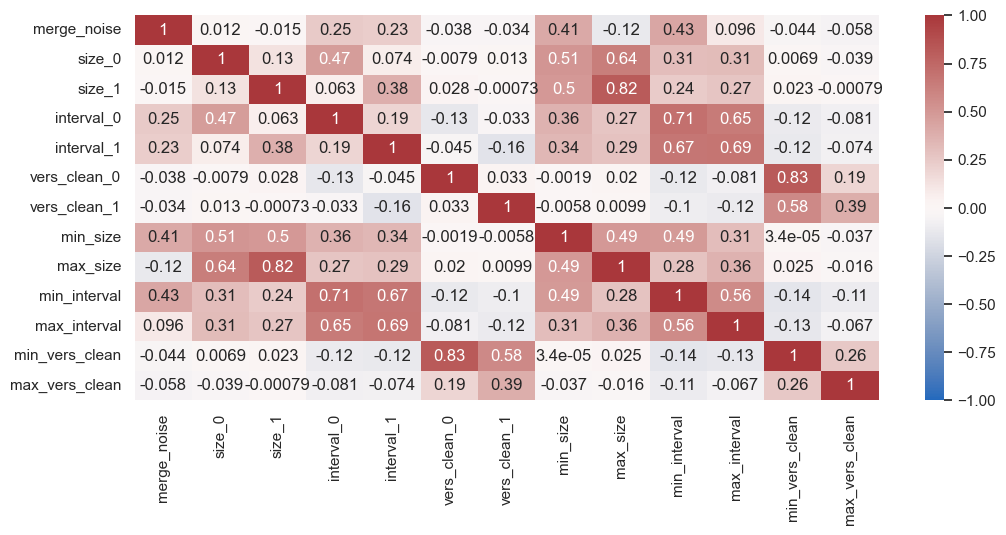

In [35]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [37]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [45]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [150]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [47]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [55]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.1

In [56]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.2553191489361702


In [81]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<Axes: >

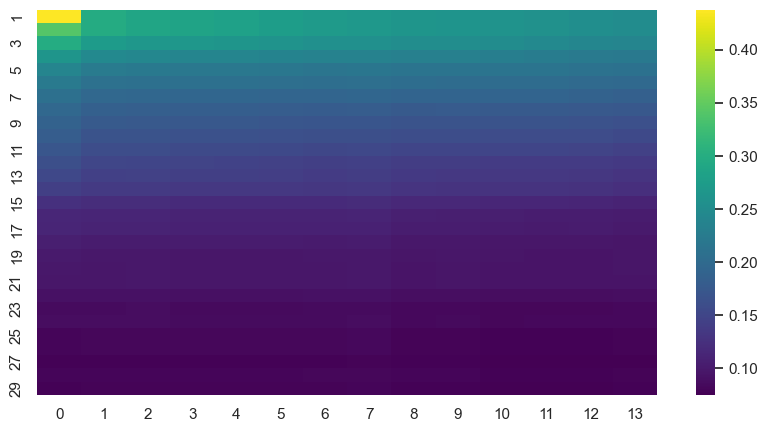

In [82]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [116]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [117]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [143]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [ ]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

In [149]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

100%|███████████████████████████████████████| 2364/2364 [00:45<00:00, 51.69it/s]


In [151]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [152]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [153]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [154]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [155]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [156]:
random_trial_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
merge_noise,2364.0,0.095604,0.139982,0.000000,0.00,0.0,0.169155,0.5
size_0,2364.0,44.963198,104.170564,1.000000,3.00,13.0,47.250000,3223.0
size_1,2364.0,44.422166,89.983561,1.000000,3.00,12.0,48.000000,1299.0
interval_0,2364.0,39.101523,34.278684,0.000000,0.00,37.0,75.000000,88.0
interval_1,2364.0,38.869712,34.388521,0.000000,0.00,37.0,75.000000,88.0
vers_clean_0,2364.0,0.996965,0.016838,0.642857,1.00,1.0,1.000000,1.0
vers_clean_1,2364.0,0.997523,0.011912,0.800000,1.00,1.0,1.000000,1.0
min_size,2364.0,29.727157,61.432150,1.000000,2.00,7.0,29.000000,834.0
max_size,2364.0,59.658206,121.353458,1.000000,5.00,20.0,70.000000,3223.0
min_interval,2364.0,31.945008,32.852540,0.000000,0.00,21.0,66.000000,88.0


<Axes: >

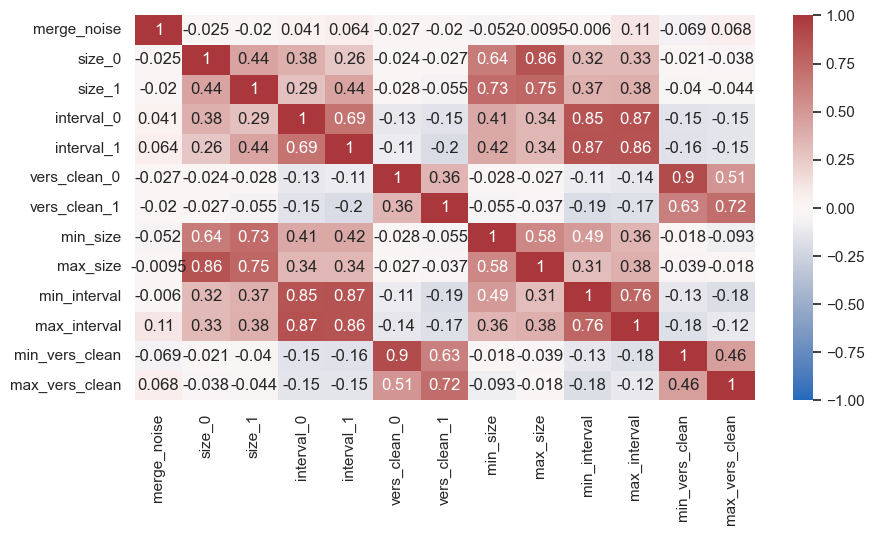

In [157]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [158]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [161]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<Axes: >

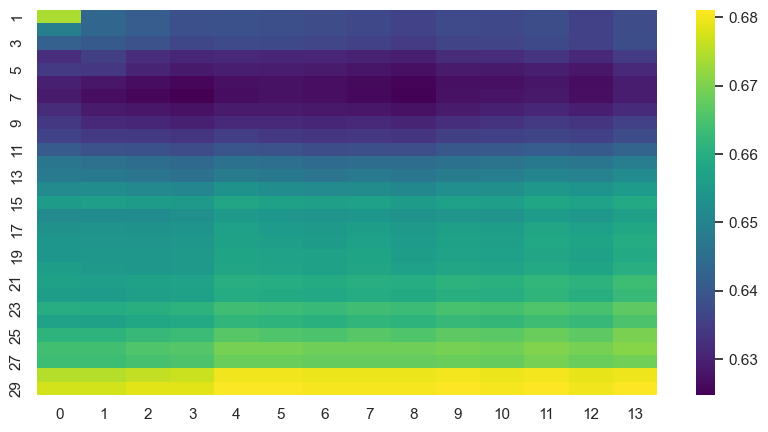

In [162]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

In [198]:
# fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# # Plot the first heatmap on the left subplot
# heatmap1 = ax[0].imshow(matrix, cmap='coolwarm')
# ax[0].set_title('Random')

# # Plot the second heatmap on the right subplot
# heatmap2 = ax[1].imshow(matrix2, cmap='coolwarm')
# ax[1].set_title('Non-Random')

# # Set the same colorbar for both subplots
# cbar = fig.colorbar(heatmap1, ax=ax.ravel().tolist(), orientation = 'horizontal', shrink=0.8)

# # Set the label for the colorbar
# cbar.ax.set_ylabel('Value')

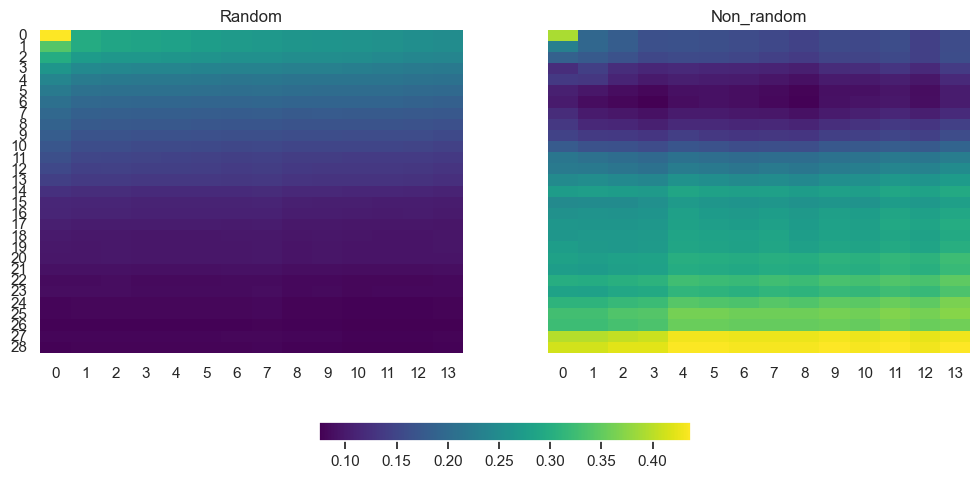

In [201]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)